In [84]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline

# 1 Client, 1 Inteferring Client, 1 MDS

In [85]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for client in data['results']:
                for line in client['stdout_lines']:
                    if "started" in line: start = line.split()[4]
                    if "finished" in line: end = line.split()[4]            
                r.append(to_seconds(end) - to_seconds(start))
    return r

def parse_delta(files):
    r = []
    o = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)       
            r.append(to_seconds(data['delta']))
            try:
                o.append(float(data['stdout']))
            except:
                o.append(0)
    return r, o

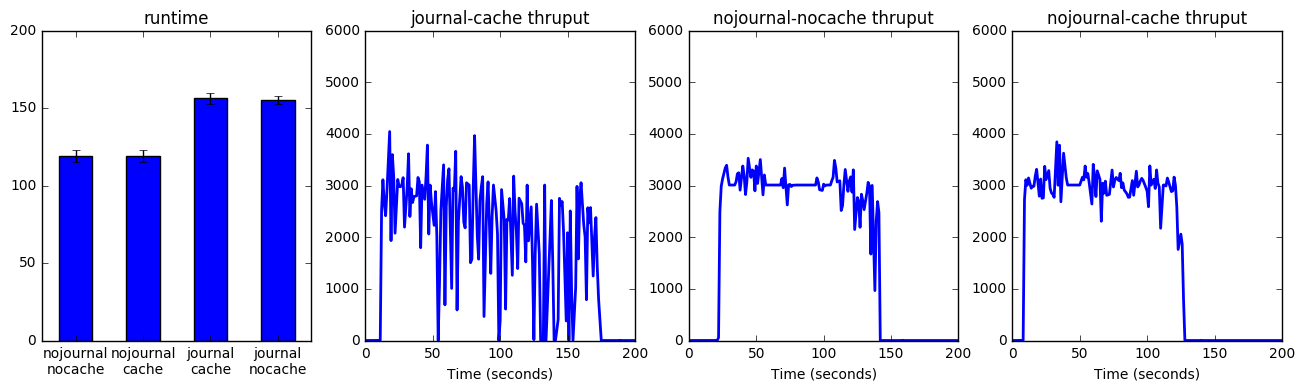

In [91]:
# plot runtimes
df = pd.DataFrame(columns=["job", "mean", "std"])
for site in ["nojournal-nocache",
             "nojournal-cache",
             "journal-cache", 
             "journal-nocache"]:
    s = 'experiments/kernel/journal/results-done/' + site + '/'
    d = parse_mdtest(glob.glob(s + 'mdtest-100000-*'))
    df.loc[len(df)] = [site.replace('-', '\n'), np.mean(d), np.std(d)]

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

df.plot.bar(ax=ax[0], y='mean', yerr='std')
ax[0].set_xticklabels(df['job'], rotation=0)
ax[0].legend().remove()
ax[0].set_title("runtime")
ax[0].set_ylim(0, 200)

# plot the throughputs
for site in [("journal-cache", 75, 1),
             ("nojournal-nocache", 75, 2),
             ("nojournal-cache", 575, 3),
             ]:
    s = 'experiments/kernel/journal/results-done/' + site[0] + '/'
    metric = "handle_client_request_tput"
    df = pd.read_csv(s + metric + '.wsp.out', skiprows=13, names=["index", "time", metric])
    df = df[df['time'] != 0]                  # filter out null timestamps
    init = float(df['time'].loc[0])           # beginning of runs shifted to 0 (unix time stamp)
    df = df.drop(df.index[range(0, site[1])]) # drop some values to line up start times
    shft = df['index'].iloc[0]                # shift timestamps to 0
    df['x'] = df['time'] - init - shft        # specify values for x axis
    df.plot(ax=ax[site[2]], x='x', y=metric, lw=2)
    ax[site[2]].set_xlim(0, 200)
    ax[site[2]].set_ylim(0, 6000)    
    ax[site[2]].set_title(site[0] + ' thruput')
    ax[site[2]].legend().remove()
    ax[site[2]].set_xlabel('Time (seconds)')

(0, 6000)

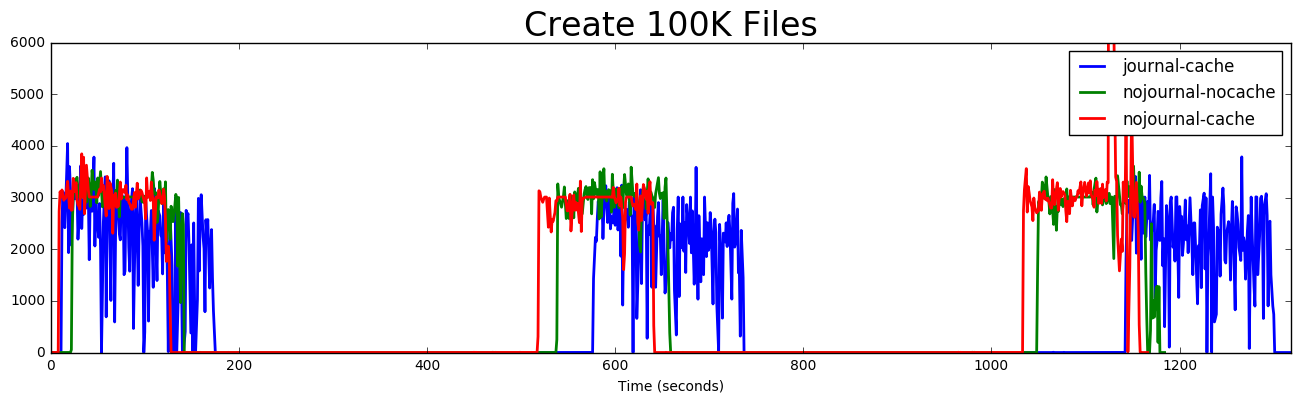

In [87]:
# plot entire run; input is (name, drop rows, ax)
fig0, ax0 = plt.subplots(1, 1, figsize=(16, 4))
for site in [("journal-cache", 75, 3),
             ("nojournal-nocache", 75, 1),
             ("nojournal-cache", 575, 2),
             ]:
    s = 'experiments/kernel/journal/results-done/' + site[0] + '/'
    metric = "handle_client_request_tput"
    df = pd.read_csv(s + metric + '.wsp.out', skiprows=13, names=["index", "time", metric])
    df = df[df['time'] != 0]                  # filter out null timestamps
    init = float(df['time'].loc[0])           # beginning of runs shifted to 0 (unix time stamp)
    df = df.drop(df.index[range(0, site[1])]) # drop some values to line up start times
    shft = df['index'].iloc[0]                # shift timestamps to 0
    df['x'] = df['time'] - init - shft        # specify values for x axis
    df.plot(ax=ax0, x='x', y=metric, label=site[0], lw=2)
ax0.set_title('Create 100K Files', fontsize=24)
ax0.set_xlabel('Time (seconds)')
ax0.legend(loc='upper right')
ax0.set_ylim(0, 6000)

... 0 ... 1 ... 14 ... 24 ... 27 ... 29 ... 34 ... kbout


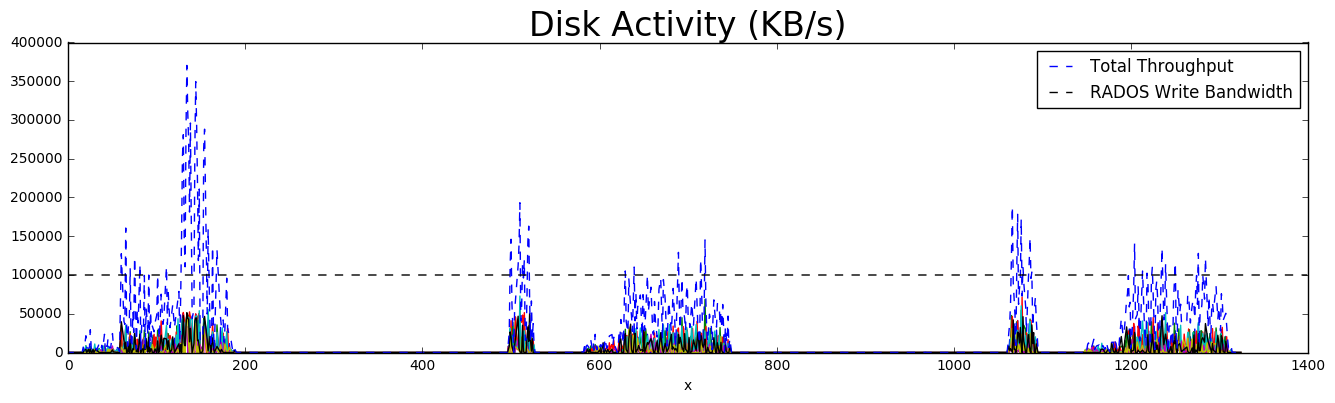

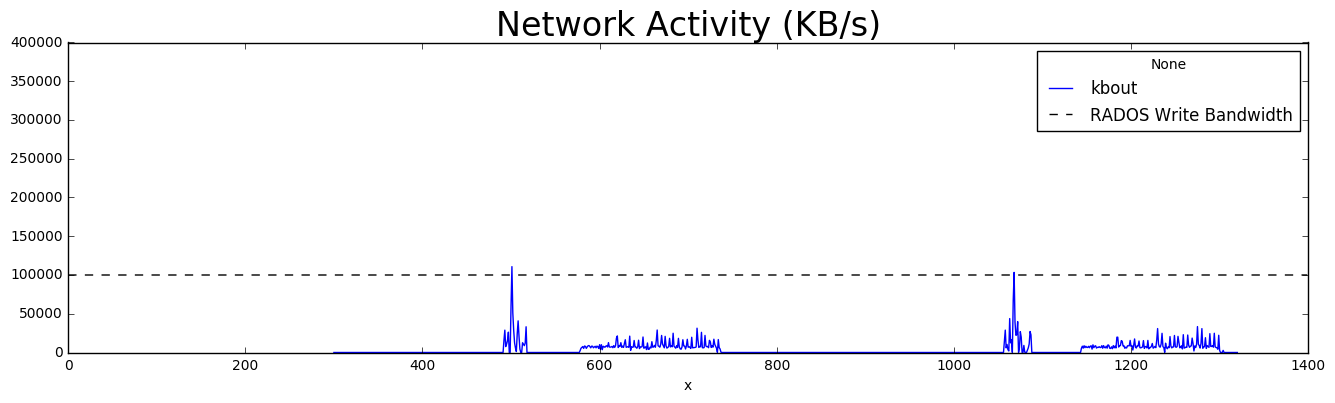

In [88]:
site = 'experiments/kernel/journal/results-done/journal-cache/'
# plot 4 is RADOS usage
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(111)
osd=40
df = pd.DataFrame(columns=['time', 'tput'])
m = "writekbs.wsp-issdm-"+str(osd)+".out"
tmp = pd.read_csv(site + m, skiprows=13, names=["index", "time", m])
init = tmp.loc[0]['time']
df['time'] = range(tmp.loc[0]['time'], tmp.loc[0]['time'] + len(tmp))
df['tput'] = np.zeros(len(tmp))

df = pd.merge(df, tmp, on=['time'])
df['tput'] = df['tput'] + df[m]
del df['index']

for osd in [0, 1, 14, 24, 27, 29, 34]:
    m = "writekbs.wsp-issdm-"+str(osd)+".out"
    tmp = pd.read_csv(site + m, skiprows=13, names=["index", "time", m])
    df = pd.merge(df, tmp, on=['time'])
    df['tput'] = df['tput'] + df[m]
    del df['index']
    print "... " + str(osd),
    df['x'] = df['time'] - init - 676
    df.plot(ax=ax, x='x', y=m) 
ax.legend(fontsize=12, loc='upper center')
ax.legend().remove()
df.plot(ax=ax, x='x', y='tput', ls='--', label="Total Throughput")
df = pd.DataFrame(columns=['tput'])
df['tput'] = np.ones(1400)*100000
df.plot(ax=ax, y='tput', ls='--', label="RADOS Write Bandwidth", color='black')
ax.set_xlim(0, 1400)
ax.set_title("Disk Activity (KB/s)", fontsize=24)

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(111)
for m in [("kbout", 1)]:
    # input is array of tuples, where first is metric and second is which graph to put it on
    df = pd.read_csv(site + m[0] + '.wsp.out', skiprows=13, names=["index", "time", m[0]])
    
    # filter out null timestamps and shift time series
    df = df[df['time'] != 0]
    init = float(df['time'].loc[0])
    df['x'] = df['time'] - init + 300
    df.plot(ax=ax, x='x', y=m[0])
    ax.set_xlim(0, 1400)
           
    # cleanup graphs
    #ax.set_xlabel('')                       
    #ax.set_xticks([])
    ax.legend(fontsize=8)
    print "... " + m[0]
df = pd.DataFrame(columns=['tput'])
df['tput'] = np.ones(1400)*100000
df.plot(ax=ax, y='tput', ls='--', label="RADOS Write Bandwidth", color='black')
ax.set_ylim(0, 400000)
ax.set_xlim(0, 1400)
ax.set_title("Network Activity (KB/s)", fontsize=24)

# Let's Zoom in on the cache

... inodes ... inodes_pinned ... inodes_pin_tail ... inodes_with_caps ... inodes_top ... inodes_bottom ... ino+ ... ino- ... inodes ... inodes_pinned ... inodes_pin_tail ... inodes_with_caps ... inodes_top ... inodes_bottom ... ino+ ... ino-

(250000, 450000)

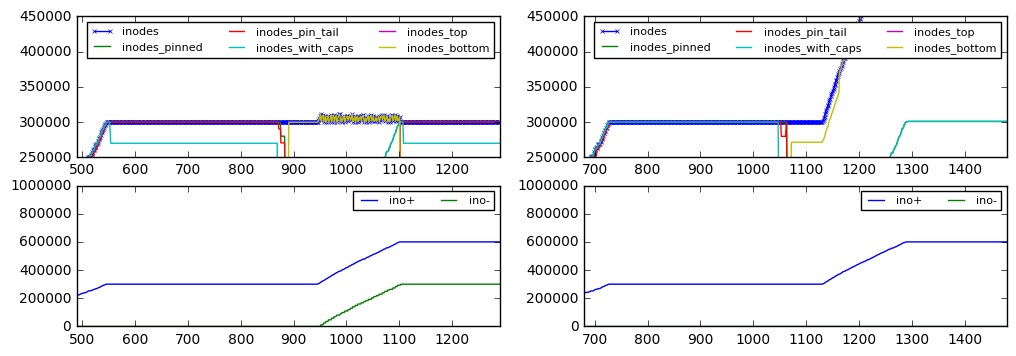

In [89]:
site = 'experiments/kernel/journal/results-done/journal-nocache/'
xlim = (490, 1290)
#xlim = (0, 1500)
init = float("inf")

# plots 0 - 3 are throughput, cpu utilization, and cache usage
fig, ax = plt.subplots(2, 2, figsize=(12, 4))
for m in [("inodes", 0), ("inodes_pinned", 0), ("inodes_pin_tail", 0),
          ("inodes_with_caps", 0), ("inodes_top", 0), ("inodes_bottom", 0),
          ("ino+", 1), ("ino-", 1)
          ]:
    # input is array of tuples, where first is metric and second is which graph to put it on
    df = pd.read_csv(site + m[0] + '.wsp.out', skiprows=13, names=["index", "time", m[0]])
    
    # filter out null timestamps and shift time series
    df = df[df['time'] != 0]
    if m[1] == 0 and m[0] == "inodes": init = float(df['time'].loc[0])
    df['x'] = df['time'] - init
    if m[0] == "inodes":
        df.plot(ax=ax[m[1]][0], x='x', y=m[0], marker='x', markersize=3)
    else:
        df.plot(ax=ax[m[1]][0], x='x', y=m[0])
    ax[m[1]][0].set_xlim(xlim[0], xlim[1])

    # cleanup graphs
    ax[m[1]][0].set_xlabel('')                       
    #ax[m[1]].set_xticks([])
    ax[m[1]][0].legend(fontsize=8, ncol=3)
    print "... " + m[0],

site = 'experiments/kernel/journal/results-done/journal-cache/'
for m in [("inodes", 0), ("inodes_pinned", 0), ("inodes_pin_tail", 0),
          ("inodes_with_caps", 0), ("inodes_top", 0), ("inodes_bottom", 0),
          ("ino+", 1), ("ino-", 1)
          ]:
    # input is array of tuples, where first is metric and second is which graph to put it on
    df = pd.read_csv(site + m[0] + '.wsp.out', skiprows=13, names=["index", "time", m[0]])
    
    # filter out null timestamps and shift time series
    df = df[df['time'] != 0]
    if m[1] == 0 and m[0] == "inodes": init = float(df['time'].loc[0])
    df['x'] = df['time'] - init
    if m[0] == "inodes":
        df.plot(ax=ax[m[1]][1], x='x', y=m[0], marker='x', markersize=3)
    else:
        df.plot(ax=ax[m[1]][1], x='x', y=m[0])
    ax[m[1]][1].set_xlim(680, 1480)

    # cleanup graphs
    ax[m[1]][1].set_xlabel('')                       
    #ax[m[1]].set_xticks([])
    ax[m[1]][1].legend(fontsize=8, ncol=3)
    print "... " + m[0],
    
ax[0][0].set_ylim(250000, 450000)
ax[0][1].set_ylim(250000, 450000)


# What is the effect of segment size

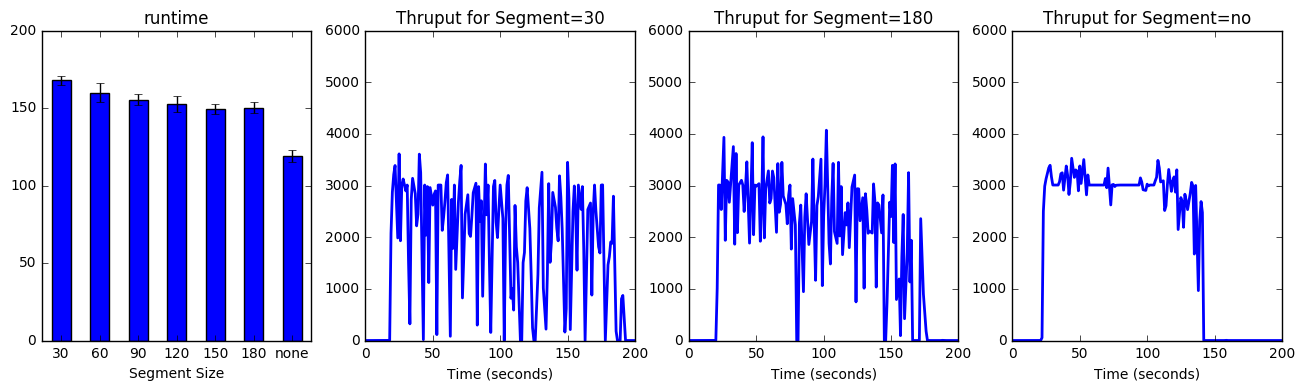

In [146]:
# plot runtimes
df = pd.DataFrame(columns=["job", "mean", "std"])
for site in ["30", "60", "90", "120", "150", "180"]:
    s = 'experiments/kernel/journal/results/journal' + site + '-cache/'
    d = parse_mdtest(glob.glob(s + 'mdtest-100000-*'))
    df.loc[len(df)] = [site.replace('-', '\n'), np.mean(d), np.std(d)]

s = "experiments/kernel/journal/results-done/nojournal-cache/"
d = parse_mdtest(glob.glob(s + 'mdtest-100000-*'))
df.loc[len(df)] = ["none", np.mean(d), np.std(d)]

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

df.plot.bar(ax=ax[0], y='mean', yerr='std')
ax[0].set_xticklabels(df['job'], rotation=0)
ax[0].legend().remove()
ax[0].set_title("runtime")
ax[0].set_ylim(0, 200)
ax[0].set_xlabel("Segment Size")

# plot the throughputs
for site in [("journal30-cache", 75, 1),
             ("journal180-cache", 75, 2),
             ("nojournal-nocache", 75, 3)
             ]:
    if site[0] == "nojournal-nocache":
        s = 'experiments/kernel/journal/results-done/' + site[0] + '/'
    else:
        s = 'experiments/kernel/journal/results/' + site[0] + '/'
    metric = "handle_client_request_tput"
    df = pd.read_csv(s + metric + '.wsp.out', skiprows=13, names=["index", "time", metric])
    df = df[df['time'] != 0]                  # filter out null timestamps
    init = float(df['time'].loc[0])           # beginning of runs shifted to 0 (unix time stamp)
    df = df.drop(df.index[range(0, site[1])]) # drop some values to line up start times
    shft = df['index'].iloc[0]                # shift timestamps to 0
    df['x'] = df['time'] - init - shft        # specify values for x axis
    df.plot(ax=ax[site[2]], x='x', y=metric, lw=2)
    ax[site[2]].set_xlim(0, 200)
    ax[site[2]].set_ylim(0, 6000)    
    ax[site[2]].set_title("Thruput for Segment=" + 
                          site[0].replace("-cache", "").replace("-nocache", "").replace("journal",""))
    ax[site[2]].legend().remove()
    ax[site[2]].set_xlabel('Time (seconds)')

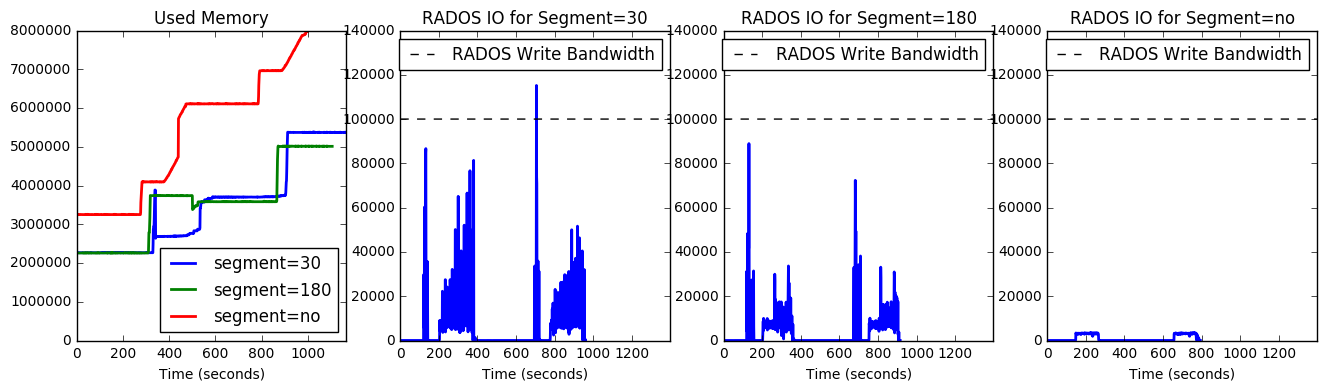

In [175]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4))

# plot the throughputs
for site in [("journal30-cache", 75, 0),
             ("journal180-cache", 75, 0),
             ("nojournal-nocache", 75, 0)
            ]:
    if site[0] == "nojournal-nocache":
        s = 'experiments/kernel/journal/results-done/' + site[0] + '/'
    else:
        s = 'experiments/kernel/journal/results/' + site[0] + '/'
    metric = "used"
    df = pd.read_csv(s + metric + '.wsp.out', skiprows=13, names=["index", "time", metric])
    df = df[df['time'] != 0]                  # filter out null timestamps
    init = float(df['time'].loc[0])           # beginning of runs shifted to 0 (unix time stamp)
    df = df.drop(df.index[range(0, site[1])]) # drop some values to line up start times
    shft = df['index'].iloc[0]                # shift timestamps to 0
    df['x'] = df['time'] - init - shft        # specify values for x axis
    df.plot(ax=ax[site[2]], x='x', y=metric, lw=2,
            label="segment=" + site[0].replace("-cache", "").replace("-nocache", "").replace("journal",""))
    ax[site[2]].set_ylim(0, 8000000)
    ax[site[2]].set_title("Used Memory")
    ax[site[2]].set_xlabel('Time (seconds)')

# plot the throughputs
for site in [("journal30-cache", 75, 1),
             ("journal180-cache", 75, 2),
             ("nojournal-nocache", 75, 3)             
             ]:
    if site[0] == "nojournal-nocache":
        s = 'experiments/kernel/journal/results-done/' + site[0] + '/'
    else:
        s = 'experiments/kernel/journal/results/' + site[0] + '/'
    metric = "kbout"
    df = pd.read_csv(s + metric + '.wsp.out', skiprows=13, names=["index", "time", metric])
    df = df[df['time'] != 0]                  # filter out null timestamps
    init = float(df['time'].loc[0])           # beginning of runs shifted to 0 (unix time stamp)
    df = df.drop(df.index[range(0, site[1])]) # drop some values to line up start times
    shft = df['index'].iloc[0]                # shift timestamps to 0
    df['x'] = df['time'] - init - shft        # specify values for x axis
    df.plot(ax=ax[site[2]], x='x', y=metric, lw=2)
    ax[site[2]].set_ylim(0, 140000)
    if site[0] == "nojournal-nocache":
        ax[site[2]].set_xlim(100, 400)
    else:
        ax[site[2]].set_xlim(100, 400)   
    ax[site[2]].set_title("RADOS IO for Segment=" + 
                          site[0].replace("-cache", "").replace("-nocache", "").replace("journal",""))
    ax[site[2]].legend(loc='upper right')    
    ax[site[2]].legend().remove()
    ax[site[2]].set_xlabel('Time (seconds)')
    df = pd.DataFrame(columns=['tput'])
    df['tput'] = np.ones(1400)*100000
    df.plot(ax=ax[site[2]], y='tput', ls='--', label="RADOS Write Bandwidth", color='black')
